In [1]:
!git clone https://github.com/ostris/ai-toolkit
!mkdir -p /content/skin_cancer_dataset

%cd ai-toolkit
!git submodule update --init --recursive
!pip install -r requirements.txt

Cloning into 'ai-toolkit'...
remote: Enumerating objects: 6138, done.
remote: Counting objects: 100% (486/486), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 6138 (delta 449), reused 374 (delta 374), pack-reused 5652 (from 3)
Receiving objects: 100% (6138/6138), 30.87 MiB | 44.09 MiB/s, done.
Resolving deltas: 100% (4321/4321), done.
/content/ai-toolkit
  Cloning https://github.com/huggingface/diffusers (to revision 363d1ab7e24c5ed6c190abb00df66d9edb74383b) to /tmp/pip-req-build-izl1lour
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-izl1lour
  Running command git rev-parse -q --verify 'sha^363d1ab7e24c5ed6c190abb00df66d9edb74383b'
  Running command git fetch -q https://github.com/huggingface/diffusers 363d1ab7e24c5ed6c190abb00df66d9edb74383b
  Running command git checkout -q 363d1ab7e24c5ed6c190abb00df66d9edb74383b
  Resolved https://github.com/huggingface/diffusers to commit 363d1ab7e24c5ed6c

In [1]:
from huggingface_hub import login
from google.colab import userdata
import wandb
import os

hf_token = userdata.get('hf_shah1st')
wandb_key = userdata.get("wandb")

login(token=hf_token)
wandb.login(key=wandb_key)
os.environ['HF_TOKEN'] = hf_token

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shah1st-work-ua (shah1st-work-ua-igor-sikorsky-kyiv-polytechnic-institute) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
import os
from PIL import Image

def convert_bmp_to_jpg(source_folder, output_folder):
    """Convert BMP files to JPG and resize to 512x512 for training"""
    os.makedirs(output_folder, exist_ok=True)

    image_files = [f for f in os.listdir(source_folder) if f.endswith('.bmp')]
    print(f"Found {len(image_files)} BMP files.")

    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]
        img_path = os.path.join(source_folder, img_file)
        txt_path = os.path.join(source_folder, f"{base_name}.txt")

        output_img_path = os.path.join(output_folder, f"{base_name}.jpg")
        output_txt_path = os.path.join(output_folder, f"{base_name}.txt")

        image = Image.open(img_path).convert('RGB')

        image.thumbnail((512, 512))

        new_image = Image.new('RGB', (512, 512), (0, 0, 0))

        offset = ((512 - image.width) // 2, (512 - image.height) // 2)
        new_image.paste(image, offset)

        new_image.save(output_img_path, 'JPEG', quality=95)

        if os.path.exists(txt_path):
            with open(txt_path, 'r', encoding='utf-8') as src_file:
                content = src_file.read()

                if not content.startswith("SKINCANCER:"):
                    content = f"SKINCANCER: {content}"

                with open(output_txt_path, 'w', encoding='utf-8') as dst_file:
                    dst_file.write(content)
        else:
            with open(output_txt_path, 'w', encoding='utf-8') as f:
                f.write("SKINCANCER: Dermatoscopic image of skin lesion")

    print(f"Converted {len(image_files)} images to JPG format at 512x512 resolution.")


In [3]:

source_folder = "/content/drive/MyDrive/Datasources/Datasets/PH2"
output_folder = "/content/skin_cancer_dataset"

convert_bmp_to_jpg(source_folder, output_folder)

Found 200 BMP files.
Converted 200 images to JPG format at 512x512 resolution.


In [4]:
import os
import sys
sys.path.append('/content/ai-toolkit')
from toolkit.job import run_job
from collections import OrderedDict

# Ensuring output directory exists
save_path = "/content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora"
os.makedirs(save_path, exist_ok=True)

job_to_run = OrderedDict([
    ('job', 'extension'),
    ('config', OrderedDict([
        # this name will be the folder and filename name
        ('name', 'skin_cancer_flux_lora'),
        ('process', [
            OrderedDict([
                ('type', 'sd_trainer'),
                # Save directly to Google Drive
                ('training_folder', '/content/drive/MyDrive/Datasources/Datasets'),
                ('device', 'cuda:0'),
                # Trigger word for your skin cancer images
                ('trigger_word', 'SKINCANCER'),
                ('network', OrderedDict([
                    ('type', 'lora'),
                    ('linear', 16),  # Good for medical details
                    ('linear_alpha', 32)
                ])),
                ('save', OrderedDict([
                    ('dtype', 'bfloat16'),  # precision to save
                    ('save_every', 250),  # save every this many steps
                    ('max_step_saves_to_keep', 4)  # how many intermittent saves to keep
                ])),
                ('datasets', [
                    OrderedDict([
                        ('folder_path', '/content/skin_cancer_dataset'),
                        ('caption_ext', 'txt'),
                        ('caption_dropout_rate', 0.05),
                        ('shuffle_tokens', False),
                        ('cache_latents_to_disk', True),
                        ('resolution', [512, 512])
                    ])
                ]),
                ('train', OrderedDict([
                    ('batch_size', 2),  # Increased for A100
                    ('steps', 2000),  # ~10x number of images is a good rule of thumb
                    ('gradient_accumulation_steps', 1),
                    ('train_unet', True),
                    ('train_text_encoder', False),
                    ('content_or_style', 'content'),  # Better for medical details
                    ('gradient_checkpointing', True),
                    ('noise_scheduler', 'flowmatch'),
                    ('optimizer', 'adamw8bit'),
                    ('lr', 2e-4),
                    ('ema_config', OrderedDict([
                        ('use_ema', True),
                        ('ema_decay', 0.99)
                    ])),
                    ('dtype', 'bf16')
                ])),
                ('model', OrderedDict([
                    ('name_or_path', 'black-forest-labs/FLUX.1-dev'),
                    ('is_flux', True),
                    ('quantize', True),
                    # A100 has plenty of VRAM
                    ('low_vram', False),
                ])),
                ('sample', OrderedDict([
                    ('sampler', 'flowmatch'),
                    ('sample_every', 250),
                    ('width', 512),
                    ('height', 512),
                    ('prompts', [
                        # Test prompts for skin cancer images
                        'SKINCANCER: Dermatoscopic image of a common nevus, fully symmetrical shape, with uniform dark brown coloration',
                        'SKINCANCER: Dermatoscopic image of melanoma with irregular borders and multiple colors',
                        'SKINCANCER: High-resolution clinical photograph of basal cell carcinoma',
                        'SKINCANCER: Dermatoscopic image of seborrheic keratosis with typical features'
                    ]),
                    ('neg', ''),  # not used on flux
                    ('seed', 42),
                    ('walk_seed', True),
                    ('guidance_scale', 3.5),
                    ('sample_steps', 28)  # Good for FLUX.1-dev
                ]))
            ])
        ])
    ])),
    ('meta', OrderedDict([
        ('name', '[name]'),
        ('version', '1.0')
    ]))
])

In [5]:
run_job(job_to_run)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


{
    "type": "sd_trainer",
    "training_folder": "/content/drive/MyDrive/Datasources/Datasets",
    "device": "cuda:0",
    "trigger_word": "SKINCANCER",
    "network": {
        "type": "lora",
        "linear": 16,
        "linear_alpha": 32
    },
    "save": {
        "dtype": "bfloat16",
        "save_every": 250,
        "max_step_saves_to_keep": 4
    },
    "datasets": [
        {
            "folder_path": "/content/skin_cancer_dataset",
            "caption_ext": "txt",
            "caption_dropout_rate": 0.05,
            "shuffle_tokens": false,
            "cache_latents_to_disk": true,
            "resolution": [
                512,
                512
            ]
        }
    ],
    "train": {
        "batch_size": 2,
        "steps": 2000,
        "gradient_accumulation_steps": 1,
        "train_unet": true,
        "train_text_encoder": false,
        "content_or_style": "content",
        "gradient_checkpointing": true,
        "noise_scheduler": "flowmatch",
  

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json:   0%|          | 0.00/121k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

(…)pytorch_model-00003-of-00003.safetensors:   0%|          | 0.00/3.87G [00:00<?, ?B/s]

(…)pytorch_model-00002-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

(…)pytorch_model-00001-of-00003.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Quantizing transformer


scheduler_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

Loading VAE


config.json:   0%|          | 0.00/820 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Loading T5


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Quantizing T5
Loading CLIP


config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

Making pipe
Preparing Model
create LoRA network. base dim (rank): 16, alpha: 16
neuron dropout: p=None, rank dropout: p=None, module dropout: p=None
create LoRA for Text Encoder: 0 modules.
create LoRA for U-Net: 494 modules.
enable LoRA for U-Net
Dataset: /content/skin_cancer_dataset
  -  Preprocessing image dimensions


100%|██████████| 200/200 [00:00<00:00, 525.62it/s]


  -  Found 200 images
Bucket sizes for /content/skin_cancer_dataset:
512x512: 200 files
1 buckets made
Caching latents for /content/skin_cancer_dataset
 - Saving latents to disk


Caching latents to disk: 100%|██████████| 200/200 [00:07<00:00, 26.46it/s]


Dataset: /content/skin_cancer_dataset
  -  Preprocessing image dimensions


100%|██████████| 200/200 [00:00<00:00, 45829.37it/s]

  -  Found 200 images
Bucket sizes for /content/skin_cancer_dataset:
512x512: 200 files
1 buckets made
Caching latents for /content/skin_cancer_dataset
 - Saving latents to disk



Caching latents to disk: 100%|██████████| 200/200 [00:00<00:00, 41443.64it/s]


Generating baseline samples before training


Generating Images: 100%|██████████| 4/4 [00:45<00:00, 11.30s/it]
                                                                


Saving at step 250
Saved checkpoint to /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/skin_cancer_flux_lora_000000250.safetensors
Saved optimizer to /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/optimizer.pt


Generating Images: 100%|██████████| 4/4 [00:45<00:00, 11.30s/it]
                                                                


Saving at step 500
Saved checkpoint to /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/skin_cancer_flux_lora_000000500.safetensors
Saved optimizer to /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/optimizer.pt


Generating Images: 100%|██████████| 4/4 [00:45<00:00, 11.30s/it]
                                                                


Saving at step 750
Saved checkpoint to /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/skin_cancer_flux_lora_000000750.safetensors
Saved optimizer to /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/optimizer.pt


Generating Images: 100%|██████████| 4/4 [00:45<00:00, 11.31s/it]
                                                                


Saving at step 1000
Saved checkpoint to /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/skin_cancer_flux_lora_000001000.safetensors
Saved optimizer to /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/optimizer.pt


Generating Images: 100%|██████████| 4/4 [00:45<00:00, 11.31s/it]
                                                                


Saving at step 1250
Saved checkpoint to /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/skin_cancer_flux_lora_000001250.safetensors
Saved optimizer to /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/optimizer.pt
Removing old save: /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/skin_cancer_flux_lora_000000250.safetensors


Generating Images: 100%|██████████| 4/4 [00:45<00:00, 11.31s/it]
                                                                


Saving at step 1500
Saved checkpoint to /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/skin_cancer_flux_lora_000001500.safetensors
Saved optimizer to /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/optimizer.pt
Removing old save: /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/skin_cancer_flux_lora_000000500.safetensors


Generating Images: 100%|██████████| 4/4 [00:45<00:00, 11.32s/it]
                                                                


Saving at step 1750
Saved checkpoint to /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/skin_cancer_flux_lora_000001750.safetensors
Saved optimizer to /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/optimizer.pt
Removing old save: /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/skin_cancer_flux_lora_000000750.safetensors


skin_cancer_flux_lora: 100%|█████████▉| 1999/2000 [1:14:03<00:02,  2.22s/it, lr: 2.0e-04 loss: 2.111e-01]



Saved checkpoint to /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/skin_cancer_flux_lora.safetensors
Saved optimizer to /content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora/optimizer.pt


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/10 [00:00<?, ?it/s]

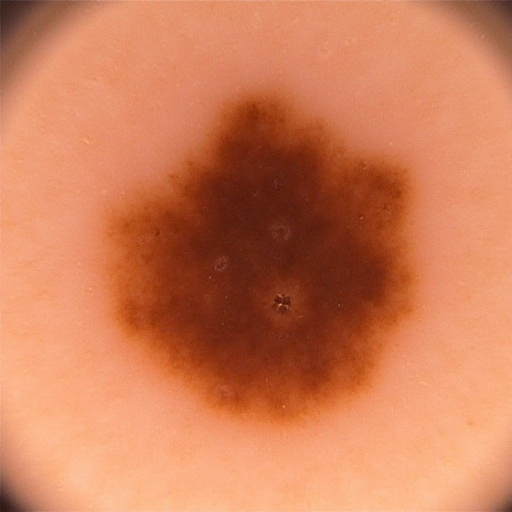

In [3]:
import torch
from diffusers import FluxPipeline

pipeline = FluxPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-dev",
    torch_dtype=torch.bfloat16
)

lora_path = "/content/drive/MyDrive/Datasources/Datasets/skin_cancer_flux_lora"
pipeline.load_lora_weights(lora_path, weight_name='skin_cancer_flux_lora.safetensors')

pipeline.enable_model_cpu_offload()

prompt = "SKINCANCER: Dermatoscopic image of a common nevus, fully symmetrical shape, with uniform dark brown coloration"
image = pipeline(
    prompt=prompt,
    num_inference_steps=10,
    guidance_scale=3.5,
    height=512,
    width=512,
).images[0]

image.save("generated_skin_image.png")

from IPython.display import display
display(image)